In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras.backend as K
import keras

Using TensorFlow backend.


In [0]:
train = pickle.load(open("hw4_tr7.pkl","rb")).reshape([-1,784])

In [0]:
test = pickle.load(open("hw4_te7.pkl","rb")).reshape([-1,784])

In [4]:
train.shape

(6265, 784)

In [5]:
test.shape

(1028, 784)

### Custom function for Leaky relu activation

In [0]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

# Tensorflow VAE Model

In [7]:
K=4
x = tf.placeholder(tf.float32, [None,784])

x_input = tf.reshape(x,[-1, 28, 28, 1])

#-------------------Encoder
w1 = tf.Variable(tf.random_uniform([3,3, 1, 16],minval=-1.0,maxval=1.0))
b1 = tf.get_variable("b1",[16], initializer=tf.constant_initializer(0.0))
conv1 = lrelu(tf.add(tf.nn.conv2d(x_input, w1, strides=[1,2,2,1], padding="SAME") , b1))

w2 = tf.Variable(tf.random_uniform([3,3, 16, 32],minval=-1.0,maxval=1.0))
b2 = tf.get_variable("b2",[32], initializer=tf.constant_initializer(0.0))
conv2 = lrelu(tf.add(tf.nn.conv2d(conv1, w2, strides=[1,2,2,1], padding="SAME") , b2))


flat = tf.reshape(conv2,[tf.shape(x)[0], 7*7*32])


w3 = tf.Variable(tf.random_normal([7*7*32,K]))
b3 = tf.get_variable("b3",[K], initializer=tf.constant_initializer(0.0))
mean = tf.add(tf.matmul(flat,w3) , b3)

w4 = tf.Variable(tf.random_normal([7*7*32,K]))
b4 = tf.get_variable("b4",[K], initializer=tf.constant_initializer(0.0))
stddev = tf.add(tf.matmul(flat,w4) , b4)

samples = tf.random_normal([tf.shape(x)[0],K],0,1,dtype=tf.float32)
z = mean + (stddev * samples)

#-------------------Decoder

w5 = tf.Variable(tf.random_normal([K,7*7*32]))
b5 = tf.get_variable("b5",[7*7*32], initializer=tf.constant_initializer(0.0))
decoder1 = tf.add(tf.matmul(z,w5) , b5)

decoder2=tf.nn.relu(tf.reshape(decoder1, [tf.shape(z)[0], 7, 7, 32]))

w6 = tf.Variable(tf.random_uniform([3,3, 16,32],minval=-1.0,maxval=1.0))
#b6 = tf.get_variable("b6",[16], initializer=tf.constant_initializer(0.0))
decoder3 = tf.nn.relu(tf.nn.conv2d_transpose(decoder2, w6, output_shape=[tf.shape(z)[0], 14, 14, 16], strides=[1,2,2,1]))


w7 = tf.Variable(tf.random_uniform([3,3, 1, 16],minval=-1.0,maxval=1.0))
#b7 = tf.get_variable("b7",[1], initializer=tf.constant_initializer(0.0))
decoder4 = tf.nn.conv2d_transpose(decoder3, w7, output_shape=[tf.shape(z)[0], 28, 28, 1], strides=[1,2,2,1])

Output = tf.nn.sigmoid(decoder4)

Instructions for updating:
Colocations handled automatically by placer.


# Model Loss and Optimizer

In [8]:
#-------------------Model Parameters
regenerated_img = tf.reshape(Output, [tf.shape(z)[0], 784])

regeneration_loss = tf.reduce_sum(tf.square(x -regenerated_img),1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(mean) + tf.square(stddev) - tf.log(tf.square(stddev)) - 1,1)

cost = tf.reduce_mean(regeneration_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

Instructions for updating:
Use tf.cast instead.


# Model to create new 7's from transformed z matrix

In [0]:
#-------------------Generating New 7's
new_7=tf.placeholder(tf.float32, [None,K])
New7_decoder1 = tf.add(tf.matmul(new_7,w5) , b5)
New7_decoder2 = tf.nn.relu(tf.reshape(New7_decoder1, [tf.shape(new_7)[0], 7, 7, 32]))
New7_decoder3 = tf.nn.relu(tf.nn.conv2d_transpose(New7_decoder2, w6, output_shape=[tf.shape(new_7)[0], 14, 14, 16], strides=[1,2,2,1]))
New7_decoder4 = tf.nn.conv2d_transpose(New7_decoder3, w7, output_shape=[tf.shape(new_7)[0], 28, 28, 1], strides=[1,2,2,1])
New7_Output = tf.nn.sigmoid(New7_decoder4)
New7_regenerated_img = tf.reshape(New7_Output, [tf.shape(new_7)[0], 784])

# Initializing the Session

In [0]:
#-------------------Generating New 7's
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Model Training

In [11]:
batch_size = 10
epochs = 100
for i in range(epochs):
    np.random.shuffle(train)
    for j in range(train.shape[0] // batch_size):
       batch = train[j*10:(j*10)+batch_size]
       sess.run(optimizer, feed_dict={x: batch})
    c,h,l=sess.run([cost,regeneration_loss,latent_loss], feed_dict={x: train})
    print("Epoch:",i,"Cost:",round(c,2),round(np.mean(h),2),round(np.mean(l),2))

0 695.47205 77.51645 617.9556
1 244.78575 76.977516 167.80824
2 175.95966 76.8943 99.06536
3 155.69954 76.882195 78.817345
4 135.7803 76.81391 58.966404
5 120.94593 76.70252 44.243397
6 114.89685 76.62155 38.275303
7 107.21102 76.48508 30.725948
8 102.42474 76.32443 26.100311
9 104.03783 75.99923 28.03861
10 94.393776 75.26009 19.13369
11 93.95802 74.55487 19.403154
12 96.903595 73.903435 23.000154
13 89.660736 72.81097 16.849766
14 98.16878 71.36466 26.80411
15 82.53281 66.861496 15.671314
16 72.99256 60.00589 12.986662
17 68.73051 57.175858 11.554648
18 65.8164 54.443077 11.3733225
19 64.8827 51.904045 12.978656
20 148.67702 52.16868 96.50833
21 72.71692 49.07126 23.64566
22 61.489346 46.6085 14.880846
23 55.946697 45.33746 10.609242
24 63.989586 46.33032 17.659267
25 62.1214 45.85612 16.265276
26 72.56942 44.657402 27.912022
27 54.76952 43.5071 11.262419
28 57.931957 42.51706 15.414899
29 53.602314 42.237183 11.365129
30 50.83657 41.62104 9.21553
31 57.484367 43.67914 13.805225
32 5

### Plotting regenerated original images

In [0]:
Regenerated_Image=sess.run(regenerated_img, feed_dict={x: train})

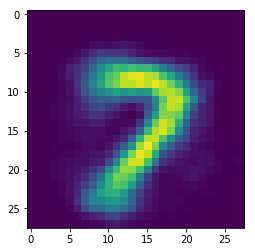

In [13]:
plt.imshow(Regenerated_Image[0].reshape(28,28))

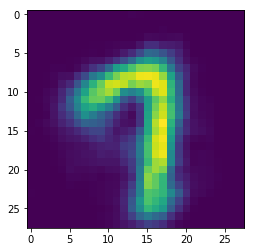

In [74]:
plt.imshow(Regenerated_Image[716].reshape(28,28))

# Analyzing Letent Embedding Matrix

In [0]:
latent=sess.run(z, feed_dict={x: train[:100]})

In [16]:
latent.shape

(100, 4)

In [0]:
masked_latent=latent.copy()
masked_latent[:,1]=[masked_latent[0,1]]*latent.shape[0]
masked_latent[:,2]=[masked_latent[0,2]]*latent.shape[0]
masked_latent[:,3]=[masked_latent[0,3]]*latent.shape[0]
New7s_Dim1=sess.run(New7_regenerated_img, feed_dict={new_7: masked_latent})

In [0]:
masked_latent=latent.copy()
masked_latent[:,0]=[masked_latent[0,0]]*latent.shape[0]
masked_latent[:,2]=[masked_latent[0,2]]*latent.shape[0]
masked_latent[:,3]=[masked_latent[0,3]]*latent.shape[0]
New7s_Dim2=sess.run(New7_regenerated_img, feed_dict={new_7: masked_latent})

In [0]:
masked_latent=latent.copy()
masked_latent[:,0]=[masked_latent[0,0]]*latent.shape[0]
masked_latent[:,1]=[masked_latent[0,1]]*latent.shape[0]
masked_latent[:,3]=[masked_latent[0,3]]*latent.shape[0]
New7s_Dim3=sess.run(New7_regenerated_img, feed_dict={new_7: masked_latent})

In [0]:
masked_latent=latent.copy()
masked_latent[:,0]=[masked_latent[0,0]]*latent.shape[0]
masked_latent[:,1]=[masked_latent[0,1]]*latent.shape[0]
masked_latent[:,2]=[masked_latent[0,2]]*latent.shape[0]
New7s_Dim4=sess.run(New7_regenerated_img, feed_dict={new_7: masked_latent})

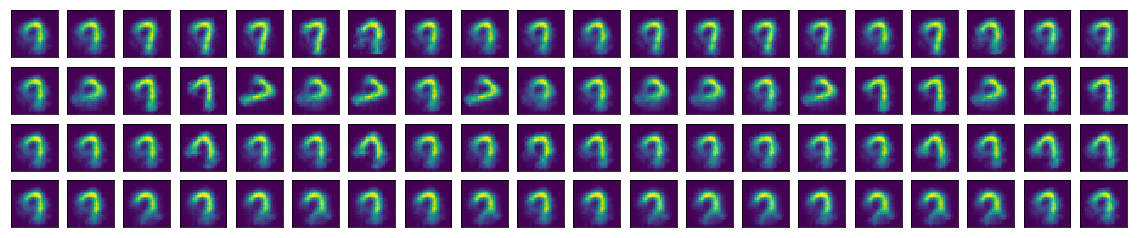

In [66]:
plt.figure(figsize=(20, 4))
for i in range(20):
  
  plt.subplot(4,20, i+1)
  plt.imshow(New7s_Dim1[i].reshape(28, 28))
  plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  plt.subplot(4,20, 20+i+1)
  plt.imshow(New7s_Dim2[i].reshape(28, 28))
  plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  plt.subplot(4,20, 40+i+1)
  plt.imshow(New7s_Dim3[i].reshape(28, 28))
  plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  plt.subplot(4,20, 60+i+1)
  plt.imshow(New7s_Dim4[i].reshape(28, 28))
  plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.show()



## Inference
**From the above plot we can see that dimensions 1,3 and 4 are very similar, while the 2nd dimension seems to have a clockwise rotational effect.**